In [15]:
import geopandas as gpd
import numpy as np
from shapely.geometry import LineString, Point
import osmnx as ox
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm

In [4]:
graph = ox.io.load_graphml("C:/Users/keyas/OneDrive/Documents/sih/map_matching_research/data/merged_graph.graphml")
# graph = ox.convert.to_undirected(graph)

In [5]:
nodes, edges = ox.graph_to_gdfs(graph)

In [6]:
angle_threshold = 15  
weights = [(15, 1), (30, 1.5), (60, 2), (180, 3)]

In [7]:
def calculate_angle(p1, p2, p3):
    """
    calculate the angle between two segments: p1-p2 and p2-p3.
    """
    v1 = np.array([p1.x - p2.x, p1.y - p2.y])
    v2 = np.array([p3.x - p2.x, p3.y - p2.y])
    angle = np.arctan2(np.linalg.norm(np.cross(v1, v2)), np.dot(v1, v2)) * (180 / np.pi)
    return angle


In [8]:
def calculate_turn_indices(edge):
    if not isinstance(edge, LineString):
        return 0, 0, 0  # Handle non-LineString geometries
    
    #edges into points
    coords = list(edge.coords)
    
    significant_turns = 0
    turn_severity = 0
    
    for i in range(1, len(coords) - 1):
        p1, p2, p3 = Point(coords[i - 1]), Point(coords[i]), Point(coords[i + 1])
        angle = calculate_angle(p1, p2, p3)
        
        if angle > angle_threshold:
            significant_turns += 1
            for threshold, weight in weights:
                if angle <= threshold:
                    turn_severity += weight
                    break
    length = edge.length  
    turn_density = significant_turns / length if length > 0 else 0
    turn_severity_index = turn_severity / length if length > 0 else 0
    
    return significant_turns, turn_density, turn_severity_index

In [11]:
edges[['significant_turns', 'turn_density', 'turn_severity_index']] = edges['geometry'].apply(
    lambda edge: pd.Series(calculate_turn_indices(edge))
)
edges.to_file("edges_with_turn_indices.geojson", driver="GeoJSON")

In [12]:
print(edges.head())
print(edges.columns)

                                                                       osmid  \
u          v          key                                                      
299669428  8118723069 0                                            871637725   
           8118723077 0                                            871637726   
299713642  5157095793 0    [736542598, 736542599, 736542600, 736542601, 7...   
           1794821112 0                    [168193394, 168193395, 168193396]   
1444103394 2787298132 0                                           1208496672   

                                highway  oneway       reversed         length  \
u          v          key                                                       
299669428  8118723069 0      trunk_link   False           True       8.038763   
           8118723077 0           trunk    True          False     881.088862   
299713642  5157095793 0         primary   False  [False, True]  114450.253575   
           1794821112 0         pr

In [14]:

print(edges[edges['significant_turns'] > 0][['significant_turns', 'turn_density', 'turn_severity_index']])


                             significant_turns  turn_density  \
u           v           key                                    
299669428   8118723077  0                 13.0   1579.533306   
299713642   5157095793  0               4988.0   4405.862206   
            1794821112  0                 45.0   5568.028068   
1444103394  1794821119  0                  1.0    702.715881   
1705557606  1705557609  0                  3.0  14765.991283   
...                                        ...           ...   
10211637282 10211637300 0                155.0   1066.315574   
10211637300 10211637282 0                155.0   1066.315574   
            10211636581 0                 62.0   2241.914487   
10281919508 1331289284  0                 27.0   3335.944757   
10281921909 10211636582 0                  1.0   2921.148974   

                             turn_severity_index  
u           v           key                       
299669428   8118723077  0            4738.599919  
299713642   51

In [25]:
print(edges['length'].describe())

count    176505.000000
mean       3019.953965
std        8796.596219
min           0.015368
25%          20.482130
50%         176.513802
75%        1377.066090
max      289997.979410
Name: length, dtype: float64


In [21]:
#start of making of heatmap for turn density
norm = Normalize(vmin=edges['turn_density'].min(), vmax=edges['turn_density'].max())
print("Min:", edges['turn_density'].min(), "Max:", edges['turn_density'].max())

Min: 0.0 Max: 253424.94007831565


In [18]:
cmap = cm.get_cmap('YlOrRd')

C:\Users\keyas\AppData\Local\Temp\ipykernel_22256\634227301.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('YlOrRd')


In [19]:
edges['color'] = edges['turn_density'].apply(lambda x: cmap(norm(x)))

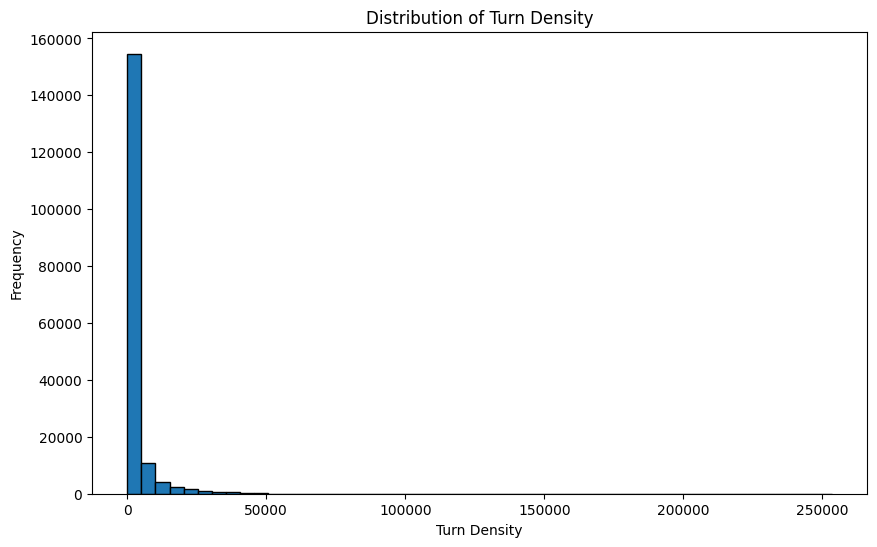

In [22]:
plt.figure(figsize=(10, 6))
edges['turn_density'].plot(kind='hist', bins=50, edgecolor='black')
plt.title('Distribution of Turn Density')
plt.xlabel('Turn Density')
plt.ylabel('Frequency')
plt.show()

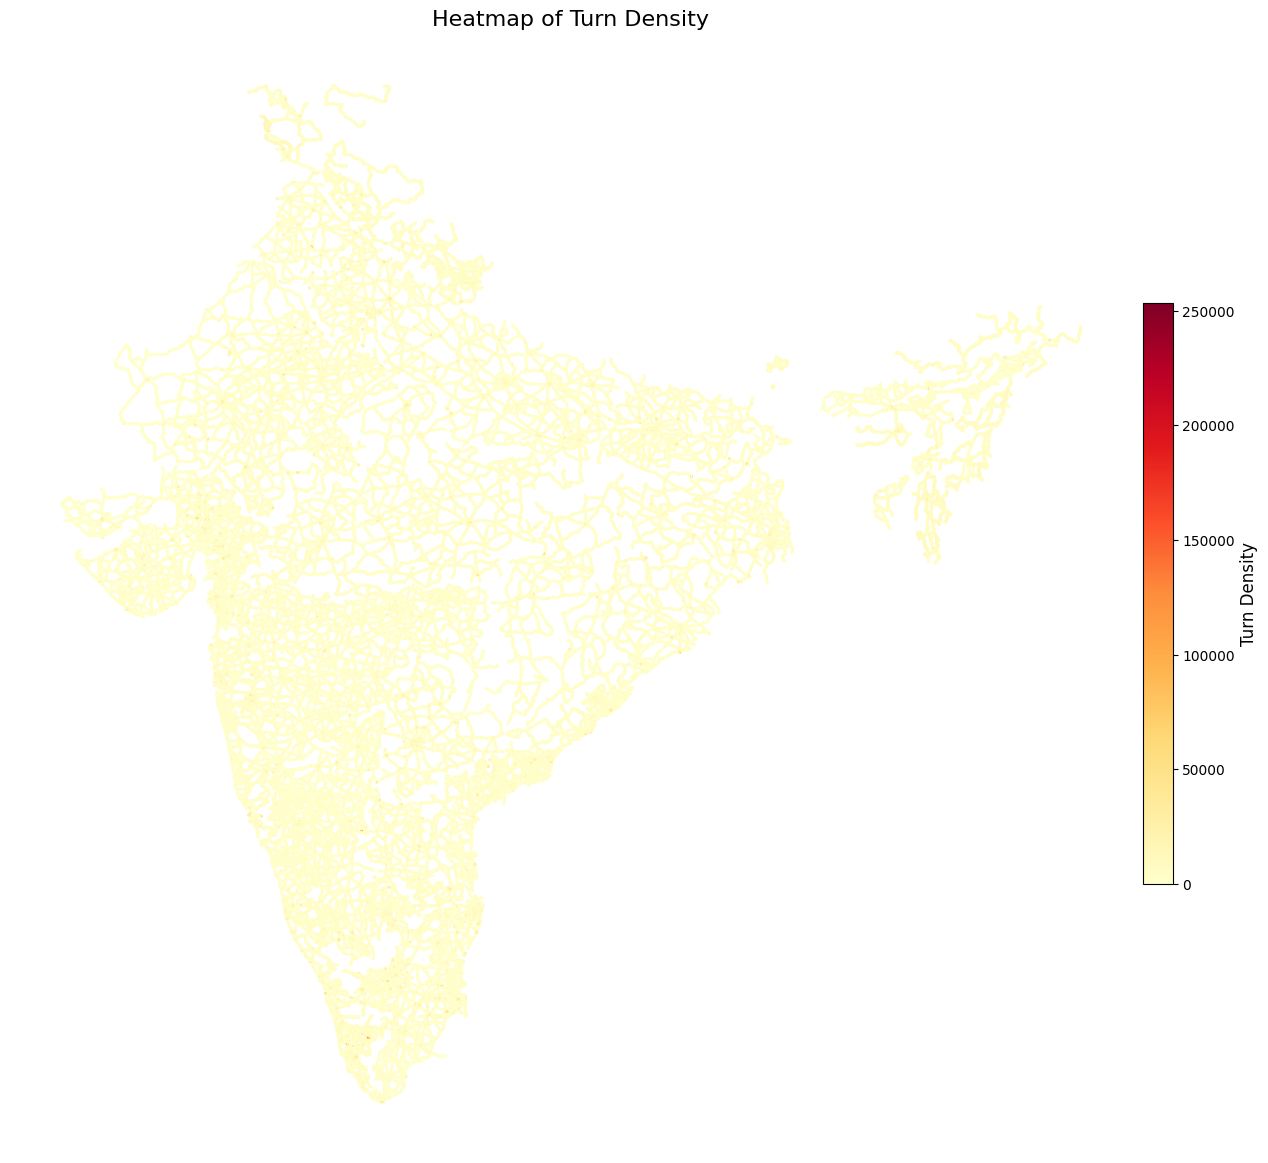

In [20]:
fig, ax = plt.subplots(figsize=(15, 15))
edges.plot(ax=ax, color=edges['color'], linewidth=2)

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.025, pad=0.01)
cbar.set_label('Turn Density', fontsize=12)

ax.set_title('Heatmap of Turn Density', fontsize=16)
ax.set_axis_off()

plt.show()